# Method 8 - Rest Ideas After 20

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 20].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

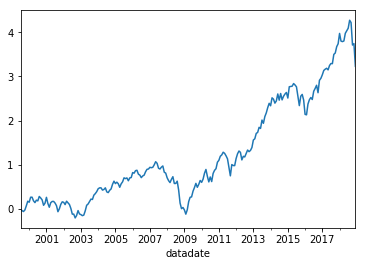

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.169313
2000-12-31   -0.038923
2001-12-31    0.028139
2002-12-31   -0.237982
2003-12-31    0.575168
2004-12-31    0.170905
2005-12-31    0.050683
2006-12-31    0.113680
2007-12-31   -0.048749
2008-12-31   -0.431705
2009-12-31    0.596963
2010-12-31    0.252755
2011-12-31   -0.037833
2012-12-31    0.207346
2013-12-31    0.420684
2014-12-31    0.072643
2015-12-31   -0.047319
2016-12-31    0.142107
2017-12-31    0.198232
2018-12-31   -0.107898
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1567.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.86e-165
Time:                        06:43:40   Log-Likelihood:                 736.03
No. Observations:                 234   AIC:                            -1462.
Df Residuals:                     229   BIC:                            -1445.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      4.354      0.000       0.002       0.005
mktrf          1.0361      0.020     52.756      0.000       0.997       1.075
me             0.3310      0.023     14.490      0.000       0.286       0.376
ia             0.0951      0.035      2.738      0.007       0.027       0.163
roe           -0.2794      0.030     -9.401      0.000      -0.338      -0.221
==============================================================================
Omnibus:                       58.310   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.096
Skew:                           0.941   Prob(JB):                     1.47e-51
Kurtosis:                       7.524   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1178.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.97e-151
Time:                        06:43:40   Log-Likelihood:                 736.03
No. Observations:                 234   AIC:                            -1462.
Df Residuals:                     229   BIC:                            -1445.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.229      0.001       0.001       0.005
mktrf          1.0361      0.024     43.593      0.000       0.989       1.083
me             0.3310      0.043      7.625      0.000       0.246       0.416
ia             0.0951      0.061      1.570      0.116      -0.024       0.214
roe           -0.2794      0.053     -5.282      0.000      -0.383      -0.176
==============================================================================
Omnibus:                       58.310   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.096
Skew:                           0.941   Prob(JB):                     1.47e-51
Kurtosis:                       7.524   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1473.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.55e-162
Time:                        06:43:40   Log-Likelihood:                 736.03
No. Observations:                 234   AIC:                            -1462.
Df Residuals:                     229   BIC:                            -1445.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.920      0.004       0.001       0.005
mktrf          1.0361      0.024     43.606      0.000       0.989       1.083
me             0.3310      0.044      7.490      0.000       0.244       0.418
ia             0.0951      0.051      1.881      0.060      -0.004       0.194
roe           -0.2794      0.056     -4.999      0.000      -0.389      -0.170
==============================================================================
Omnibus:                       58.310   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.096
Skew:                           0.941   Prob(JB):                     1.47e-51
Kurtosis:                       7.524   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     969.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.02e-151
Time:                        06:43:40   Log-Likelihood:                 707.67
No. Observations:                 234   AIC:                            -1403.
Df Residuals:                     228   BIC:                            -1383.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.751      0.006       0.001       0.004
mktrf          1.0905      0.022     48.987      0.000       1.047       1.134
smb            0.3948      0.029     13.441      0.000       0.337       0.453
hml            0.0692      0.035      1.997      0.047       0.001       0.137
rmw           -0.1479      0.039     -3.777      0.000      -0.225      -0.071
cma            0.0366      0.050      0.735      0.463      -0.061       0.135
==============================================================================
Omnibus:                       94.253   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.701
Skew:                           1.509   Prob(JB):                    2.29e-108
Kurtosis:                       9.460   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     827.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.06e-144
Time:                        06:43:40   Log-Likelihood:                 707.67
No. Observations:                 234   AIC:                            -1403.
Df Residuals:                     228   BIC:                            -1383.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.285      0.022       0.000       0.004
mktrf          1.0905      0.019     56.239      0.000       1.052       1.129
smb            0.3948      0.043      9.281      0.000       0.311       0.478
hml            0.0692      0.066      1.053      0.293      -0.060       0.198
rmw           -0.1479      0.057     -2.594      0.009      -0.260      -0.036
cma            0.0366      0.080      0.458      0.647      -0.120       0.193
==============================================================================
Omnibus:                       94.253   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.701
Skew:                           1.509   Prob(JB):                    2.29e-108
Kurtosis:                       9.460   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1057.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.66e-155
Time:                        06:43:40   Log-Likelihood:                 707.67
No. Observations:                 234   AIC:                            -1403.
Df Residuals:                     228   BIC:                            -1383.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.008      0.045    5.41e-05       0.004
mktrf          1.0905      0.019     57.788      0.000       1.054       1.127
smb            0.3948      0.036     10.882      0.000       0.324       0.466
hml            0.0692      0.060      1.158      0.247      -0.048       0.186
rmw           -0.1479      0.065     -2.291      0.022      -0.274      -0.021
cma            0.0366      0.079      0.464      0.643      -0.118       0.191
==============================================================================
Omnibus:                       94.253   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.701
Skew:                           1.509   Prob(JB):                    2.29e-108
Kurtosis:                       9.460   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1619.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.35e-166
Time:                        06:43:40   Log-Likelihood:                 739.69
No. Observations:                 234   AIC:                            -1469.
Df Residuals:                     229   BIC:                            -1452.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.740      0.000       0.001       0.004
mktrf          1.0504      0.018     59.008      0.000       1.015       1.085
smb            0.4749      0.022     21.371      0.000       0.431       0.519
hml            0.0832      0.022      3.769      0.000       0.040       0.127
umd           -0.1517      0.014    -10.474      0.000      -0.180      -0.123
==============================================================================
Omnibus:                       28.198   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.883
Skew:                           0.516   Prob(JB):                     1.49e-16
Kurtosis:                       5.532   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1232.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.44e-153
Time:                        06:43:41   Log-Likelihood:                 739.69
No. Observations:                 234   AIC:                            -1469.
Df Residuals:                     229   BIC:                            -1452.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.672      0.008       0.001       0.004
mktrf          1.0504      0.020     52.947      0.000       1.011       1.089
smb            0.4749      0.027     17.324      0.000       0.421       0.529
hml            0.0832      0.052      1.587      0.113      -0.020       0.186
umd           -0.1517      0.024     -6.375      0.000      -0.198      -0.105
==============================================================================
Omnibus:                       28.198   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.883
Skew:                           0.516   Prob(JB):                     1.49e-16
Kurtosis:                       5.532   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1448.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.03e-161
Time:                        06:43:41   Log-Likelihood:                 739.69
No. Observations:                 234   AIC:                            -1469.
Df Residuals:                     229   BIC:                            -1452.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.332      0.020       0.000       0.005
mktrf          1.0504      0.017     62.891      0.000       1.018       1.083
smb            0.4749      0.026     18.055      0.000       0.423       0.526
hml            0.0832      0.054      1.538      0.124      -0.023       0.189
umd           -0.1517      0.021     -7.360      0.000      -0.192      -0.111
==============================================================================
Omnibus:                       28.198   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.883
Skew:                           0.516   Prob(JB):                     1.49e-16
Kurtosis:                       5.532   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     655.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.98e-78
Time:                        06:43:41   Log-Likelihood:                 351.94
No. Observations:                 120   AIC:                            -693.9
Df Residuals:                     115   BIC:                            -679.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.001      4.026      0.000       0.003       0.008
mktrf          1.0266      0.034     30.264      0.000       0.959       1.094
me             0.2845      0.034      8.491      0.000       0.218       0.351
ia             0.1242      0.052      2.366      0.020       0.020       0.228
roe           -0.3148      0.046     -6.779      0.000      -0.407      -0.223
==============================================================================
Omnibus:                       19.406   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.899
Skew:                           0.730   Prob(JB):                     7.18e-08
Kurtosis:                       5.109   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     849.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.32e-84
Time:                        06:43:41   Log-Likelihood:                 351.94
No. Observations:                 120   AIC:                            -693.9
Df Residuals:                     115   BIC:                            -679.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      3.018      0.003       0.002       0.008
mktrf          1.0266      0.033     31.566      0.000       0.963       1.090
me             0.2845      0.047      6.040      0.000       0.192       0.377
ia             0.1242      0.075      1.650      0.099      -0.023       0.272
roe           -0.3148      0.064     -4.922      0.000      -0.440      -0.189
==============================================================================
Omnibus:                       19.406   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.899
Skew:                           0.730   Prob(JB):                     7.18e-08
Kurtosis:                       5.109   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1309.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.18e-95
Time:                        06:43:41   Log-Likelihood:                 351.94
No. Observations:                 120   AIC:                            -693.9
Df Residuals:                     115   BIC:                            -679.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.677      0.007       0.001       0.009
mktrf          1.0266      0.031     32.708      0.000       0.965       1.088
me             0.2845      0.050      5.728      0.000       0.187       0.382
ia             0.1242      0.061      2.052      0.040       0.006       0.243
roe           -0.3148      0.066     -4.742      0.000      -0.445      -0.185
==============================================================================
Omnibus:                       19.406   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.899
Skew:                           0.730   Prob(JB):                     7.18e-08
Kurtosis:                       5.109   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     399.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.66e-70
Time:                        06:43:41   Log-Likelihood:                 336.93
No. Observations:                 120   AIC:                            -661.9
Df Residuals:                     114   BIC:                            -645.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.001      3.102      0.002       0.002       0.007
mktrf          1.1491      0.041     28.223      0.000       1.068       1.230
smb            0.3798      0.046      8.235      0.000       0.288       0.471
hml            0.0339      0.057      0.599      0.550      -0.078       0.146
rmw           -0.1046      0.067     -1.570      0.119      -0.237       0.027
cma            0.0955      0.073      1.308      0.193      -0.049       0.240
==============================================================================
Omnibus:                       38.346   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.262
Skew:                           1.206   Prob(JB):                     2.79e-22
Kurtosis:                       6.747   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     473.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.74e-74
Time:                        06:43:41   Log-Likelihood:                 336.93
No. Observations:                 120   AIC:                            -661.9
Df Residuals:                     114   BIC:                            -645.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.652      0.008       0.001       0.008
mktrf          1.1491      0.031     36.742      0.000       1.088       1.210
smb            0.3798      0.058      6.533      0.000       0.266       0.494
hml            0.0339      0.097      0.347      0.728      -0.157       0.225
rmw           -0.1046      0.079     -1.329      0.184      -0.259       0.050
cma            0.0955      0.095      1.007      0.314      -0.090       0.281
==============================================================================
Omnibus:                       38.346   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.262
Skew:                           1.206   Prob(JB):                     2.79e-22
Kurtosis:                       6.747   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     777.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.59e-86
Time:                        06:43:41   Log-Likelihood:                 336.93
No. Observations:                 120   AIC:                            -661.9
Df Residuals:                     114   BIC:                            -645.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.372      0.018       0.001       0.008
mktrf          1.1491      0.027     42.343      0.000       1.096       1.202
smb            0.3798      0.049      7.728      0.000       0.283       0.476
hml            0.0339      0.091      0.372      0.710      -0.144       0.212
rmw           -0.1046      0.085     -1.226      0.220      -0.272       0.063
cma            0.0955      0.092      1.039      0.299      -0.085       0.276
==============================================================================
Omnibus:                       38.346   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.262
Skew:                           1.206   Prob(JB):                     2.79e-22
Kurtosis:                       6.747   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     724.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.62e-80
Time:                        06:43:41   Log-Likelihood:                 357.69
No. Observations:                 120   AIC:                            -705.4
Df Residuals:                     115   BIC:                            -691.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.001      4.079      0.000       0.002       0.007
mktrf          1.0607      0.028     37.234      0.000       1.004       1.117
smb            0.4709      0.032     14.519      0.000       0.407       0.535
hml            0.0911      0.032      2.803      0.006       0.027       0.155
umd           -0.1615      0.020     -8.060      0.000      -0.201      -0.122
==============================================================================
Omnibus:                        7.679   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               10.308
Skew:                           0.324   Prob(JB):                      0.00578
Kurtosis:                       4.281   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     715.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.06e-80
Time:                        06:43:41   Log-Likelihood:                 357.69
No. Observations:                 120   AIC:                            -705.4
Df Residuals:                     115   BIC:                            -691.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.001      3.395      0.001       0.002       0.008
mktrf          1.0607      0.030     35.077      0.000       1.001       1.120
smb            0.4709      0.037     12.856      0.000       0.399       0.543
hml            0.0911      0.073      1.253      0.210      -0.051       0.233
umd           -0.1615      0.026     -6.126      0.000      -0.213      -0.110
==============================================================================
Omnibus:                        7.679   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               10.308
Skew:                           0.324   Prob(JB):                      0.00578
Kurtosis:                       4.281   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     823.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.33e-83
Time:                        06:43:41   Log-Likelihood:                 357.69
No. Observations:                 120   AIC:                            -705.4
Df Residuals:                     115   BIC:                            -691.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.002      2.978      0.003       0.002       0.008
mktrf          1.0607      0.026     41.263      0.000       1.010       1.111
smb            0.4709      0.038     12.468      0.000       0.397       0.545
hml            0.0911      0.076      1.194      0.233      -0.058       0.241
umd           -0.1615      0.023     -7.131      0.000      -0.206      -0.117
==============================================================================
Omnibus:                        7.679   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               10.308
Skew:                           0.324   Prob(JB):                      0.00578
Kurtosis:                       4.281   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1761.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.06e-98
Time:                        06:43:41   Log-Likelihood:                 427.36
No. Observations:                 114   AIC:                            -844.7
Df Residuals:                     109   BIC:                            -831.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.405      0.018       0.000       0.003
mktrf          1.0360      0.017     60.476      0.000       1.002       1.070
me             0.4337      0.026     16.396      0.000       0.381       0.486
ia            -0.0008      0.037     -0.021      0.984      -0.073       0.072
roe           -0.2421      0.032     -7.510      0.000      -0.306      -0.178
==============================================================================
Omnibus:                        5.845   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.270
Skew:                          -0.479   Prob(JB):                       0.0717
Kurtosis:                       3.439   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2242.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.18e-103
Time:                        06:43:41   Log-Likelihood:                 427.36
No. Observations:                 114   AIC:                            -844.7
Df Residuals:                     109   BIC:                            -831.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      2.833      0.005       0.000       0.002
mktrf          1.0360      0.016     63.198      0.000       1.004       1.068
me             0.4337      0.024     18.133      0.000       0.387       0.481
ia            -0.0008      0.035     -0.021      0.983      -0.070       0.068
roe           -0.2421      0.024    -10.045      0.000      -0.289      -0.195
==============================================================================
Omnibus:                        5.845   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.270
Skew:                          -0.479   Prob(JB):                       0.0717
Kurtosis:                       3.439   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3216.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.20e-112
Time:                        06:43:41   Log-Likelihood:                 427.36
No. Observations:                 114   AIC:                            -844.7
Df Residuals:                     109   BIC:                            -831.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.030      0.002       0.000       0.002
mktrf          1.0360      0.016     63.527      0.000       1.004       1.068
me             0.4337      0.021     20.435      0.000       0.392       0.475
ia            -0.0008      0.039     -0.020      0.984      -0.077       0.075
roe           -0.2421      0.023    -10.636      0.000      -0.287      -0.197
==============================================================================
Omnibus:                        5.845   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.270
Skew:                          -0.479   Prob(JB):                       0.0717
Kurtosis:                       3.439   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1245.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.98e-94
Time:                        06:43:41   Log-Likelihood:                 420.93
No. Observations:                 114   AIC:                            -829.9
Df Residuals:                     108   BIC:                            -813.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.484      0.629      -0.001       0.002
mktrf          1.0502      0.017     60.477      0.000       1.016       1.085
smb            0.4166      0.028     14.779      0.000       0.361       0.473
hml            0.0583      0.036      1.623      0.108      -0.013       0.130
rmw           -0.2531      0.044     -5.749      0.000      -0.340      -0.166
cma           -0.0442      0.056     -0.791      0.431      -0.155       0.067
==============================================================================
Omnibus:                        3.039   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.483
Skew:                          -0.337   Prob(JB):                        0.289
Kurtosis:                       3.260   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1226.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.22e-93
Time:                        06:43:41   Log-Likelihood:                 420.93
No. Observations:                 114   AIC:                            -829.9
Df Residuals:                     108   BIC:                            -813.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.475      0.635      -0.001       0.002
mktrf          1.0502      0.015     68.958      0.000       1.020       1.080
smb            0.4166      0.025     16.960      0.000       0.368       0.465
hml            0.0583      0.042      1.383      0.167      -0.024       0.141
rmw           -0.2531      0.043     -5.901      0.000      -0.337      -0.169
cma           -0.0442      0.055     -0.805      0.421      -0.152       0.063
==============================================================================
Omnibus:                        3.039   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.483
Skew:                          -0.337   Prob(JB):                        0.289
Kurtosis:                       3.260   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1555.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.44e-99
Time:                        06:43:41   Log-Likelihood:                 420.93
No. Observations:                 114   AIC:                            -829.9
Df Residuals:                     108   BIC:                            -813.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.413      0.680      -0.001       0.002
mktrf          1.0502      0.014     74.672      0.000       1.023       1.078
smb            0.4166      0.023     18.011      0.000       0.371       0.462
hml            0.0583      0.046      1.278      0.201      -0.031       0.148
rmw           -0.2531      0.040     -6.298      0.000      -0.332      -0.174
cma           -0.0442      0.061     -0.725      0.468      -0.164       0.075
==============================================================================
Omnibus:                        3.039   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.483
Skew:                          -0.337   Prob(JB):                        0.289
Kurtosis:                       3.260   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1341.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.12e-91
Time:                        06:43:41   Log-Likelihood:                 412.07
No. Observations:                 114   AIC:                            -814.1
Df Residuals:                     109   BIC:                            -800.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.779e-05      0.001      0.102      0.919      -0.001       0.001
mktrf          1.0592      0.019     57.056      0.000       1.022       1.096
smb            0.4789      0.029     16.546      0.000       0.422       0.536
hml            0.0633      0.030      2.123      0.036       0.004       0.122
umd           -0.0959      0.022     -4.267      0.000      -0.141      -0.051
==============================================================================
Omnibus:                        4.838   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.225
Skew:                          -0.414   Prob(JB):                        0.121
Kurtosis:                       3.451   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1198.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.44e-89
Time:                        06:43:41   Log-Likelihood:                 412.07
No. Observations:                 114   AIC:                            -814.1
Df Residuals:                     109   BIC:                            -800.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.779e-05      0.001      0.101      0.919      -0.001       0.001
mktrf          1.0592      0.017     60.846      0.000       1.025       1.093
smb            0.4789      0.028     17.391      0.000       0.425       0.533
hml            0.0633      0.041      1.543      0.123      -0.017       0.144
umd           -0.0959      0.022     -4.388      0.000      -0.139      -0.053
==============================================================================
Omnibus:                        4.838   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.225
Skew:                          -0.414   Prob(JB):                        0.121
Kurtosis:                       3.451   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1608.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.66e-96
Time:                        06:43:41   Log-Likelihood:                 412.07
No. Observations:                 114   AIC:                            -814.1
Df Residuals:                     109   BIC:                            -800.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.779e-05      0.001      0.093      0.926      -0.001       0.002
mktrf          1.0592      0.016     64.643      0.000       1.027       1.091
smb            0.4789      0.021     23.084      0.000       0.438       0.520
hml            0.0633      0.043      1.465      0.143      -0.021       0.148
umd           -0.0959      0.020     -4.918      0.000      -0.134      -0.058
==============================================================================
Omnibus:                        4.838   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.225
Skew:                          -0.414   Prob(JB):                        0.121
Kurtosis:                       3.451   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""